# TrueSkill

Findings:
* TrueSkill pre-race rating is highly correlated (0.73) with 複勝率
* Diff between competitors' mean ratings contributes 5 points to precision (big!) so this is more important than just the horse rating itself.
* pre-race rating alone contributes 1-2 point increase in precision.
* Takes about 2.5 minutes to calculate ratings for all horses since 1999
* SHAP values show that when TrueSkill rating is high, the model is more likely to predict a loss, which is weird. This only happens if we include pre-race rating and mean difference at the same time. If we remove the mean diff, the SHAP values make sense.
* Just including rating / mean diff alone doesn't perform as well as including both, especially in terms of 回収率.
* Using `mu` results in 1.5% better precision than using `exposure` for the rating.
* Including `sigma` features also improves precision by 4-5%

![shap_bar_2v__rops.png](/Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/49/39b26853181348fb8756d9fbe52da6e0/artifacts/shap_bar_2v__rops.png)

![shap_beeswarm_oadz_bi5.png](/Users/hankehly/Projects/JapanHorseRaceAnalytics/mlruns/49/39b26853181348fb8756d9fbe52da6e0/artifacts/shap_beeswarm_oadz_bi5.png)

In [1]:
import japanize_matplotlib
import pandas as pd
import trueskill
from hyperopt import SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

from JapanHorseRaceAnalytics.utilities.base import get_spark_session, read_hive_table
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

japanize_matplotlib.japanize()
random_state = 42

In [2]:
spark = get_spark_session()

24/03/20 09:51:53 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/03/20 09:51:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/03/20 09:51:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/20 09:51:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
data = read_hive_table(
    table_name="features_20240304_v1",
    schema="jhra_curated",
    spark_session=spark,
    # use_cache=False,
    parse_dates=["meta_発走日時"],
)

rows_before = data.shape[0]
logger.info(f"Original data length: {rows_before}")

# Drop from data where cat_トラック種別 == "障害"
# Keep only horses that have 3 races
# Keep only data from 2000 onwards
data = data[
    # (data["cat_トラック種別"] != "障害")
    (~data["meta_着順"].isna())
    # & (data["meta_異常区分"] == "0")
    # & (data["num_1走前着順"].notnull())
    # & (data["num_2走前着順"].notnull())
    # & (data["num_3走前着順"].notnull())
    # & (data["meta_発走日時"] >= "2000-01-01")
]

rows_after = data.shape[0]
logger.info(
    f"Data length after filtering: {rows_after} (dropped {rows_before - rows_after} rows, {100 * (rows_before - rows_after) / rows_before:.2f}%)"
)

# Interpolate missing values for num_馬体重 (20 instances from 1999 ~ 2017)
data["num_馬体重"] = (
    data.sort_values("meta_発走日時")
    .groupby("meta_血統登録番号")["num_馬体重"]
    .transform(lambda x: x.interpolate(method="linear", limit_direction="both"))
)

data.reset_index(drop=True, inplace=True)
data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240304_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-03-20T00:51:55.289566Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Original data length: 1217019", "level": "info", "timestamp": "2024-03-20T00:51:55.823310Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Data length after filtering: 1206122 (dropped 10897 rows, 0.90%)", "level": "info", "timestamp": "2024-03-20T00:51:56.172070Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_単勝払戻金,meta_複勝払戻金,meta_レースキー,meta_馬番,meta_血統登録番号,meta_発走日時,meta_単勝的中,meta_単勝オッズ,meta_複勝的中,meta_複勝オッズ,...,num_6走前3着タイム差,cat_トラック種別,num_距離,cat_距離区分,num_過去3走重み付き着順成績,num_入厩何日前逆数,cat_堅実な馬,cat_過去3走中1走訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり
0,0,0,09025206,11,00100027,2002-12-01 12:45:00+09:00,0,38.6,0,4.4,...,NaN,芝,1600,マイル,NaN,1.0,False,False,False,False
1,0,0,08032303,04,00100027,2003-02-08 10:55:00+09:00,0,39.5,0,11.8,...,NaN,ダート,1800,中距離,NaN,1.0,False,False,False,False
2,0,0,08032801,14,00100027,2003-02-23 10:00:00+09:00,0,31.0,0,3.7,...,NaN,ダート,1800,中距離,NaN,1.0,False,False,False,False
3,0,0,09031403,07,00100027,2003-03-09 10:55:00+09:00,0,17.2,0,2.3,...,NaN,ダート,1800,中距離,0.173651,1.0,False,False,False,False
4,0,0,09031701,10,00100027,2003-03-22 10:05:00+09:00,0,20.8,0,2.7,...,NaN,ダート,1800,中距離,0.177772,1.0,False,False,False,False


In [5]:
import pandas as pd
import trueskill
import tqdm

# Assuming df is your DataFrame
df_sorted = data.sort_values(by=["meta_発走日時", "meta_レースキー"])

# Initialize the TrueSkill environment
env = trueskill.TrueSkill(draw_probability=0)  # No draws in horse racing

# Initialize ratings for all horses
horse_ratings = {
    horse_id: env.create_rating()
    for horse_id in df_sorted["meta_血統登録番号"].unique()
}

# Placeholder for ratings at each point in time
df_sorted["rating_post_race"] = pd.NA
df_sorted["rating_post_race_expose"] = pd.NA
df_sorted["rating_confidence_post_race"] = pd.NA

# Iterate through races in chronological order
for (race_datetime, race_id), race_data in tqdm.tqdm(df_sorted.groupby(["meta_発走日時", "meta_レースキー"])):
    race_results = race_data.sort_values("meta_着順")
    horse_ids = race_results["meta_血統登録番号"].tolist()
    horse_groups = [[horse_ratings[horse_id]] for horse_id in horse_ids]
    ranks = list(range(len(horse_groups)))  # Lower rank number means a better position

    # Update ratings based on the race outcome
    updated_ratings = env.rate(horse_groups, ranks=ranks)

    # Directly update the DataFrame with the new ratings
    for index, (horse_id, new_rating_group) in zip(race_results.index, zip(horse_ids, updated_ratings)):
        horse_ratings[horse_id] = new_rating_group[0]  # Update with new rating
        df_sorted.at[index, "rating_post_race_expose"] = trueskill.expose(horse_ratings[horse_id])
        df_sorted.at[index, "rating_post_race"] = horse_ratings[horse_id].mu  # Directly assign the rating
        df_sorted.at[index, "rating_confidence_post_race"] = horse_ratings[horse_id].sigma
        # df_sorted.at[index, "rating_post_race"] = env.expose(horse_ratings[horse_id])  # Directly assign the rating

100%|██████████| 86237/86237 [02:44<00:00, 524.23it/s]


In [6]:
# Lag the rating_post_race by one row per horse (meta_血統登録番号) chronologically (meta_発走日時)
df_sorted["rating_pre_race"] = (
    df_sorted.sort_values("meta_発走日時")
    .groupby("meta_血統登録番号")["rating_post_race"]
    .shift(1)
    .fillna(env.mu)
    # .fillna(0.0) # when using exposure, default to 0
)

df_sorted["rating_confidence_pre_race"] = (
    df_sorted.sort_values("meta_発走日時")
    .groupby("meta_血統登録番号")["rating_confidence_post_race"]
    .shift(1)
    .fillna(env.sigma)
)

In [8]:
# Step 1: Calculate the total rating sum for each race
race_rating_sum = df_sorted.groupby("meta_レースキー")["rating_pre_race"].transform("sum")

# Step 2: Calculate the count of horses in each race
race_horse_count = df_sorted.groupby("meta_レースキー")["rating_pre_race"].transform("count")

# Step 3: Calculate the mean competitor rating for each horse
df_sorted["mean_competitor_rating_pre_race"] = (race_rating_sum - df_sorted["rating_pre_race"]) / (race_horse_count - 1)

# Step 4: Calculate the rating difference for each horse with respect to the mean competitor rating
df_sorted["mean_competitor_rating_pre_race_diff"] = df_sorted["rating_pre_race"] - df_sorted["mean_competitor_rating_pre_race"]

In [9]:
# Step 1: Calculate the total rating sum for each race
race_rating_confidence_sum = df_sorted.groupby("meta_レースキー")["rating_confidence_pre_race"].transform("sum")

# Step 2: Calculate the count of horses in each race
race_horse_count = df_sorted.groupby("meta_レースキー")["rating_confidence_pre_race"].transform("count")

# Step 3: Calculate the mean competitor rating for each horse
df_sorted["mean_competitor_rating_confidence_pre_race"] = (race_rating_sum - df_sorted["rating_confidence_pre_race"]) / (race_horse_count - 1)

# Step 4: Calculate the rating difference for each horse with respect to the mean competitor rating
df_sorted["mean_competitor_rating_confidence_pre_race_diff"] = df_sorted["rating_confidence_pre_race"] - df_sorted["mean_competitor_rating_confidence_pre_race"]

<Axes: >

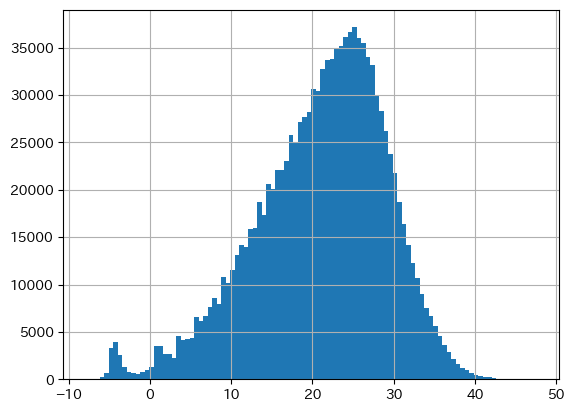

In [11]:
df_sorted.rating_post_race.hist(bins=100)

In [10]:
df_final = df_sorted[
    (df_sorted["cat_トラック種別"] != "障害")
    & (df_sorted["num_1走前着順"].notnull())
    & (df_sorted["num_2走前着順"].notnull())
    & (df_sorted["num_3走前着順"].notnull())
]

In [11]:
from sklearn.model_selection import train_test_split


X = df_final.copy()
y = X["meta_複勝的中"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (664910, 119)
X_test: (166228, 119)
y_train: (664910,)
y_test: (166228,)


In [12]:
import mlflow
import tempfile
import re
import japanize_matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import warnings
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from hyperopt import STATUS_OK
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_payout_rate,
    kelly_criterion
)

from JapanHorseRaceAnalytics.utilities.plot import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_feature_importances,
    plot_shap_interaction_values,
    plot_correlation_matrix,
)



def create_objective_fn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    payouts: pd.DataFrame,
    payout_column_name: str,
    mlflow_experiment_name: str,
):
    """
    payouts should have the same index as *_test and have the following columns:
    * 発走日時
    * odds
    * payout
    """

    def train(params):
        mlflow.set_experiment(experiment_name=mlflow_experiment_name)
        with mlflow.start_run():
            ########################################################################################
            # decay_rate = params["features__decay_rate"]

            for df in [X_train, X_test]:
                # 1. Weighted average position
                df["num_1走前標準化着順"] = (df["num_1走前着順"] - 1) / (df["num_1走前頭数"] - 1)
                df["num_2走前標準化着順"] = (df["num_2走前着順"] - 1) / (df["num_2走前頭数"] - 1)
                df["num_3走前標準化着順"] = (df["num_3走前着順"] - 1) / (df["num_3走前頭数"] - 1)
                # We want our factor (num_1走前経過日数) to start from 0
                # so subtract the minimum value for "days since last race" across all horses
                # Add a small number to avoid division by zero
                df["num_1走前重み"] = 1 / (df["num_1走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
                df["num_2走前重み"] = 1 / (df["num_2走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
                df["num_3走前重み"] = 1 / (df["num_3走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
                # df["num_2走前重み"] = np.exp(-decay_rate * (df["num_2走前経過日数"] - df["num_1走前経過日数"].min()))
                # df["num_3走前重み"] = np.exp(-decay_rate * (df["num_3走前経過日数"] - df["num_1走前経過日数"].min()))
                # Calculate weighted average of the feature
                # weighted_feature_values = np.average([value for _, value in races], weights=weights)
                df["num_過去3走重み付き標準化着順"] = (
                    (df["num_1走前標準化着順"] * df["num_1走前重み"])
                    + (df["num_2走前標準化着順"] * df["num_2走前重み"])
                    + (df["num_3走前標準化着順"] * df["num_3走前重み"])
                ) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])

                # 2. Weighted average time difference between the horse and the 3 horses behind it
                df["num_1走前後続馬平均タイム差"] = (
                    df[["num_1走前後続馬1タイム差", "num_1走前後続馬2タイム差", "num_1走前後続馬3タイム差"]]
                    .mean(axis=1)
                    .fillna(0)
                )
                df["num_2走前後続馬平均タイム差"] = (
                    df[["num_2走前後続馬1タイム差", "num_2走前後続馬2タイム差", "num_2走前後続馬3タイム差"]]
                    .mean(axis=1)
                    .fillna(0)
                )
                df["num_3走前後続馬平均タイム差"] = (
                    df[["num_3走前後続馬1タイム差", "num_3走前後続馬2タイム差", "num_3走前後続馬3タイム差"]]
                    .mean(axis=1)
                    .fillna(0)
                )
                df["num_過去3走重み付き後続馬平均タイム差"] = (
                    (df["num_1走前後続馬平均タイム差"] * df["num_1走前重み"])
                    + (df["num_2走前後続馬平均タイム差"] * df["num_2走前重み"])
                    + (df["num_3走前後続馬平均タイム差"] * df["num_3走前重み"])
                ) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])
            ########################################################################################
            preprocessor = ColumnTransformer(
                transformers=[
                    (
                        "num",
                        StandardScaler(),
                        [
                            "num_複勝率",
                            "num_1走前経過日数",
                            "num_過去3走重み付き標準化着順",
                            "num_過去3走重み付き後続馬平均タイム差",
                            # "mean_competitor_rating_pre_race",
                            "mean_competitor_rating_pre_race_diff",
                            "rating_pre_race",
                            "rating_confidence_pre_race",
                            "mean_competitor_rating_confidence_pre_race_diff",
                        ],
                    ),
                ],
                remainder="drop",
            )

            # Get all keys from params where the key starts with "smote__" and remove "smote__" from the key
            smote_params = {k.split("__")[1]: v for k, v in params.items() if k.startswith("smote__")}

            # do the same for classifier
            classifier_params = {k.split("__")[1]: v for k, v in params.items() if k.startswith("classifier__")}

            model = ImblearnPipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("smote", SMOTE(**smote_params)),
                    ("classifier", LGBMClassifier(**classifier_params)),
                ]
            )

            LGBMClassifier.feature_importances_

            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)
            y_pred = model.predict(X_test)

            metrics = {
                "loss": -precision_score(y_test, y_pred),
                "log_loss": log_loss(y_test, y_proba[:, 1]),
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "roc_auc": roc_auc_score(y_test, y_pred),
            }

            mlflow.log_params(classifier_params)
            mlflow.log_metrics(metrics)
            mlflow.sklearn.log_model(sk_model=model, artifact_path="model")

            payout = calculate_payout_rate(
                payouts=payouts,
                y_test=y_test,
                y_proba_true=y_proba[:, 1],
                groupby=[
                    ("all", None),
                    ("month", payouts["発走日時"].dt.month),
                    ("season", payouts["発走日時"].dt.month % 12 // 3),
                    ("year", payouts["発走日時"].dt.year),
                ],
                payout_column_name=payout_column_name,
            )

            # Save payout rates as csv
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".csv") as f:
                payout.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # Log payout rates as metrics
            payout_metrics = {}
            for group_name, group in payout.groupby("group"):
                for i, row in group.iterrows():
                    key = re.sub(r"\W", "_", f"payout_rate_{group_name}_{row['part']}")
                    payout_metrics[key] = row["payout_rate"]
            mlflow.log_metrics(payout_metrics)

            # Suppress UserWarning messages from matplotlib
            warnings.filterwarnings("ignore", category=UserWarning)

            # Confusion Matrix
            fig, axes = plot_confusion_matrix(y_test, y_pred)
            with tempfile.NamedTemporaryFile(
                prefix="confusion_matrix_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # ROC Curve
            fig, ax = plot_roc_curve(y_test, y_proba[:, 1])
            with tempfile.NamedTemporaryFile(prefix="roc_curve_", suffix=".png") as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Plot
            fig, ax = plot_feature_importances(
                preprocessor.get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
                top_n=50,
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Data
            feature_importances = zip(
                preprocessor.get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
            )
            feature_importances_df = (
                pd.DataFrame(feature_importances, columns=["feature", "importance"])
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(prefix="feature_importance_", suffix=".csv") as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)
            
            # SHAP values
            X_test_sample = X_test.sample(n=5000, random_state=42)
            X_test_sample_prep = preprocessor.transform(X_test_sample)
            explainer = shap.TreeExplainer(
                model=model.named_steps["classifier"],
                feature_names=preprocessor.get_feature_names_out(),
            )
            # Because we are working with a binary classifier, we only need the SHAP values for the positive class.
            # E.g., if you change 1->0 the waterfall plot flips backwards only.
            shap_values = explainer(X_test_sample_prep)[:, :, 1]
            shap_interaction_values = explainer.shap_interaction_values(X_test_sample_prep)

            # SHAP beeswarm plot
            shap.plots.beeswarm(shap_values, show=False)
            plt.tight_layout()
            with tempfile.NamedTemporaryFile(prefix="shap_beeswarm_", suffix=".png") as f:
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # SHAP interaction values heatmap
            fig, ax = plot_shap_interaction_values(shap_interaction_values, preprocessor.get_feature_names_out())
            with tempfile.NamedTemporaryFile(prefix="shap_interactions_", suffix=".png") as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # SHAP bar plot
            shap.plots.bar(shap_values, show=False)
            plt.tight_layout()
            with tempfile.NamedTemporaryFile(prefix="shap_bar_", suffix=".png") as f:
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Correlation matrix
            fig, ax = plot_correlation_matrix(data=preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())
            with tempfile.NamedTemporaryFile(prefix="correlation_matrix_", suffix=".png") as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            return {"status": STATUS_OK, "params": params, "model": model, **metrics}

    return train

In [13]:
space = {
    "smote__random_state": random_state,
    "classifier__boosting_type": "gbdt",
    "classifier__learning_rate": hp.loguniform("learning_rate", -5, 0),  # between e^-5 and 1
    "classifier__n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 1)),
    "classifier__max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    "classifier__num_leaves": scope.int(hp.quniform("num_leaves", 20, 150, 1)),
    "classifier__min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 500, 1)),
    "classifier__feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "classifier__lambda_l1": hp.uniform("lambda_l1", 0, 5),
    "classifier__lambda_l2": hp.uniform("lambda_l2", 0, 5),
    "classifier__min_split_gain": hp.uniform("min_split_gain", 0, 1),
    "classifier__min_child_weight": hp.uniform("min_child_weight", 0.001, 10),
    "classifier__subsample": hp.uniform("subsample", 0.5, 1),
    "classifier__colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "classifier__reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "classifier__reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
    "classifier__objective": "binary",
    "classifier__verbose": -1,
    "classifier__random_state": random_state,
}

In [14]:
payouts = (
    X_test[["meta_発走日時", "meta_複勝払戻金", "meta_複勝オッズ"]]
    .reset_index(drop=True)
    .rename(
        columns={
            "meta_発走日時": "発走日時",
            "meta_複勝払戻金": "payout",
            "meta_複勝オッズ": "odds",
        }
    )
    .assign(発走日時=lambda x: pd.to_datetime(x["発走日時"]))
)

experiment_name = "20240316-eda2-both-mu-sigma"
if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)

fn = create_objective_fn(
    X_train,
    y_train,
    X_test,
    y_test,
    payouts=payouts,
    payout_column_name="payout",
    mlflow_experiment_name=experiment_name,
)

In [15]:
# trials = Trials()
# fmin(
#     fn=fn,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=1,
#     trials=trials,
# )

trials = SparkTrials(parallelism=3, spark_session=spark)
fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.001563 seconds
TPE using 0 trials
build_posterior_wrapper took 0.081475 seconds
TPE using 1/1 trials with best loss inf
build_posterior_wrapper took 0.001503 seconds
TPE using 2/2 trials with best loss inf
build_posterior_wrapper took 0.001622 seconds
TPE using 3/3 trials with best loss inf
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 2:>    (0 + 1) / 1]1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


  3%|▎         | 1/30 [00:40<19:22, 40.08s/trial, best loss: -0.44030334106979]

build_posterior_wrapper took 0.001847 seconds
TPE using 4/4 trials with best loss -0.440303
Setuptools is replacing distutils.) / 1][Stage 1:>                  (0 + 1) / 1]
Closing down clientserver connection                                            


  7%|▋         | 2/30 [01:08<15:27, 33.12s/trial, best loss: -0.45775745977744703]

build_posterior_wrapper took 0.001501 secondse 3:>                  (0 + 1) / 1]
TPE using 5/5 trials with best loss -0.457757
Setuptools is replacing distutils.
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 4:>    (0 + 1) / 1]
Closing down clientserver connection                                            


 10%|█         | 3/30 [02:34<25:52, 57.51s/trial, best loss: -0.47163882917148997]

build_posterior_wrapper took 0.001597 secondse 4:>                  (0 + 1) / 1]
TPE using 6/6 trials with best loss -0.471639
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 5:>    (0 + 1) / 1]
Closing down clientserver connection                                            


 13%|█▎        | 4/30 [03:34<25:22, 58.54s/trial, best loss: -0.4813488405077654] 

build_posterior_wrapper took 0.001509 secondse 5:>                  (0 + 1) / 1]
TPE using 7/7 trials with best loss -0.481349
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 6:>    (0 + 1) / 1]
Closing down clientserver connection                                            


 17%|█▋        | 5/30 [05:14<30:33, 73.36s/trial, best loss: -0.4813488405077654]

build_posterior_wrapper took 0.001690 seconds
TPE using 8/8 trials with best loss -0.481349
Closing down clientserver connection                                            


 20%|██        | 6/30 [05:32<21:51, 54.63s/trial, best loss: -0.4842728904847397]

build_posterior_wrapper took 0.001561 secondse 7:>                  (0 + 1) / 1]
TPE using 9/9 trials with best loss -0.484273
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 8:>    (0 + 1) / 1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 23%|██▎       | 7/30 [06:37<22:10, 57.85s/trial, best loss: -0.4842728904847397]

build_posterior_wrapper took 0.001553 secondse 8:>                  (0 + 1) / 1]
TPE using 10/10 trials with best loss -0.484273
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 9:>    (0 + 1) / 1]
Closing down clientserver connection                                            


 27%|██▋       | 8/30 [07:28<20:28, 55.83s/trial, best loss: -0.4842728904847397]

build_posterior_wrapper took 0.086643 secondse 9:>                  (0 + 1) / 1]
TPE using 11/11 trials with best loss -0.484273                                 
Closing down clientserver connection


 30%|███       | 9/30 [07:30<13:36, 38.87s/trial, best loss: -0.4842728904847397]

build_posterior_wrapper took 0.001533 seconds
TPE using 12/12 trials with best loss -0.484273
Setuptools is replacing distutils.0:>   (0 + 1) / 1][Stage 11:>   (0 + 1) / 1]1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 33%|███▎      | 10/30 [08:12<13:19, 39.99s/trial, best loss: -0.4842728904847397]

build_posterior_wrapper took 0.001627 seconds
TPE using 13/13 trials with best loss -0.484273
Closing down clientserver connection                                            


 37%|███▋      | 11/30 [08:15<08:59, 28.40s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001536 seconds
TPE using 14/14 trials with best loss -0.486299
Closing down clientserver connection                                            


 40%|████      | 12/30 [08:35<07:45, 25.88s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001778 seconds
TPE using 15/15 trials with best loss -0.486299
Setuptools is replacing distutils.3:>   (0 + 1) / 1][Stage 14:>   (0 + 1) / 1]1]
Setuptools is replacing distutils.
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 43%|████▎     | 13/30 [09:26<09:30, 33.56s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001546 seconds
TPE using 16/16 trials with best loss -0.486299
Setuptools is replacing distutils.3:>   (0 + 1) / 1][Stage 15:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 47%|████▋     | 14/30 [09:58<08:50, 33.15s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001448 secondse 13:>                 (0 + 1) / 1]
TPE using 17/17 trials with best loss -0.486299
Setuptools is replacing distutils.3:>   (0 + 1) / 1][Stage 16:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 50%|█████     | 15/30 [12:52<18:51, 75.43s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001505 seconds
TPE using 18/18 trials with best loss -0.486299
Setuptools is replacing distutils.6:>   (0 + 1) / 1][Stage 17:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 53%|█████▎    | 16/30 [13:24<14:33, 62.38s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001550 secondse 16:>                 (0 + 1) / 1]
TPE using 19/19 trials with best loss -0.486299
Setuptools is replacing distutils.6:>   (0 + 1) / 1][Stage 18:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 57%|█████▋    | 17/30 [14:41<14:31, 67.04s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001689 seconds
TPE using 20/20 trials with best loss -0.486299
Closing down clientserver connection                                            


 60%|██████    | 18/30 [15:01<10:32, 52.68s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001694 seconds
TPE using 21/21 trials with best loss -0.486299
Closing down clientserver connection                                            


 63%|██████▎   | 19/30 [15:07<07:05, 38.72s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001667 seconds
TPE using 22/22 trials with best loss -0.486299
Setuptools is replacing distutils.0:>   (0 + 1) / 1][Stage 21:>   (0 + 1) / 1]
Setuptools is replacing distutils.
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 67%|██████▋   | 20/30 [16:36<08:58, 53.85s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001603 secondse 20:>                 (0 + 1) / 1]
TPE using 23/23 trials with best loss -0.486299
Closing down clientserver connection                                            


 70%|███████   | 21/30 [16:57<06:35, 43.98s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001631 seconds
TPE using 24/24 trials with best loss -0.486299
Setuptools is replacing distutils.2:>   (0 + 1) / 1][Stage 23:>   (0 + 1) / 1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 73%|███████▎  | 22/30 [18:53<08:45, 65.74s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001597 seconds
TPE using 25/25 trials with best loss -0.486299
Closing down clientserver connection                                (0 + 1) / 1]


 77%|███████▋  | 23/30 [18:55<05:25, 46.55s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001476 seconds
TPE using 26/26 trials with best loss -0.486299
Setuptools is replacing distutils.4:>   (0 + 1) / 1][Stage 25:>   (0 + 1) / 1]1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 80%|████████  | 24/30 [20:16<05:41, 56.86s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001761 seconds
TPE using 27/27 trials with best loss -0.486299
Setuptools is replacing distutils.5:>   (0 + 1) / 1][Stage 26:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 83%|████████▎ | 25/30 [20:44<04:01, 48.25s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001559 secondse 26:>                 (0 + 1) / 1]
TPE using 28/28 trials with best loss -0.486299
Closing down clientserver connection                                            


 87%|████████▋ | 26/30 [21:01<02:34, 38.73s/trial, best loss: -0.48629937326920275]

build_posterior_wrapper took 0.001504 secondse 27:>                 (0 + 1) / 1]
TPE using 29/29 trials with best loss -0.486299
Setuptools is replacing distutils.7:>   (0 + 1) / 1][Stage 28:>   (0 + 1) / 1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 90%|█████████ | 27/30 [22:04<02:18, 46.06s/trial, best loss: -0.48629937326920275]

Closing down clientserver connection                                            


 93%|█████████▎| 28/30 [22:10<01:08, 34.10s/trial, best loss: -0.48629937326920275]

Closing down clientserver connection                                            


 97%|█████████▋| 29/30 [22:17<00:25, 25.99s/trial, best loss: -0.48629937326920275]

Setuptools is replacing distutils.                                  (0 + 1) / 1]
Closing down clientserver connection                                            


100%|██████████| 30/30 [25:25<00:00, 50.85s/trial, best loss: -0.486558037212424]  

Queue empty, exiting run.
Closing down clientserver connection
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.


{'colsample_bytree': 0.5585821876657846,
 'feature_fraction': 0.8232022730849241,
 'lambda_l1': 4.033613525430295,
 'lambda_l2': 0.6796479681897603,
 'learning_rate': 0.17869131591184476,
 'max_depth': 6.0,
 'min_child_samples': 52.0,
 'min_child_weight': 1.6156724500279371,
 'min_split_gain': 0.2938780014580466,
 'n_estimators': 916.0,
 'num_leaves': 101.0,
 'reg_alpha': 0.26936955523575307,
 'reg_lambda': 0.9966121490086561,
 'subsample': 0.8973387640163732}